# Applied Data Science Project | IBM Data Science Professional Certificate
## Title: Where to setup more pharmacy outlets?
### Table of Content:
- <a href='#Introduction'>Introduction: Problem Statement</a>
- <a href='#Data Definition'>Data Definition</a>
- <a href='#Methodology'>Methodology</a>
- <a href='#Analysis'>Data Analysis</a>
- <a href='#Results/Discussion'>Results/Discussion</a>
- <a href='#Conclusion'>Conclusion</a>

<a id='Introduction'></a>
### Introduction: Problem Statement
Pharmacy outlets have become growingly important as one stop centers for drugs, supplement, medical and surgical supplies and consultation. This is induced  by the population increase within the areas of inhabitant. 

Despite the need of setting up more outlets, study on the demographic from the point of interest(POI) and existing outlets is required to understand the strategic location in order for the outlets to be accessible. 

The POIs will be the key influece to the success of pharmacy outlets. The POIs in vicinity can be, but not limited to Hospital/Medical Centers, Department Store, Shopping Mall, Residential Building, Tourist Information Center, Market, Resorts etc. 
       
The project aim to provide location recommendation based the analysis conducted on the point of interest and neighboring pharmacy outlets, believing that these places can easily attract consumers who are enroute to the specific POIs or those who need drugs/medical supply or prescription which near to the infirmary.


<a id='Data Definition'></a>
### Data Definition
This project is to address the areas in Tanjung Tokong, Penang which are lacking pharmacy outlets and to propose new locations for outlets to be set up. 

Data collection is based on the radius of the target neighborhood grouped as Neighborhood/Venue, Latitude and Longitude. The landmarks from the geographic coordinates will be mapped using Folium library.

The factors to be considered for decision on the recommended locations are:
- Number of point of interest that influence setting up of pharmacy outlets
- Number of existing pharmacy outlets in vicinity
- Residential or city demographics

I will focus on the areas where the center of where the POIs are located.  
The approach of retrieving the pharmacy location and related information is by means of the Foursquare API.


### Methodology
To obtain the geographic coordinates of the target borough, I will first search and retrieve the neighborhood coordinates from the area of Tanjung Tokong. 
I will then explore block radius to discover the landmarks based on the data with the use of Foursquare API.

Next, designated POIs will be segregated out from the landmarks together with the existing pharmacy outlets for visualiation to better understand the mapping of respective locations.

Finally, the POI and existing outlets coordinates will be fed into k-Mean clustering model to map out the best locations for new outlets.  



In [1]:
import os
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', 400)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

# import beautiful soup
from bs4 import BeautifulSoup

# import geocoder
import geocoder # import geocoder

# import Counter 
from collections import Counter

# import seaborn
import seaborn as sns

# import progress bar object
from tqdm.notebook import tqdm


print('Libraries imported.')

Libraries imported.


### Obtain the latitude and longitude of Neighborhood and visualize the region
#### Create a function that output geographic coordinates

In [2]:
def output_geo_coordinates(address):
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude, longitude

In [3]:
address = 'Tanjung Tokong, Penang'
latitude, longitude = output_geo_coordinates(address)
print(f'The geograpical coordinate of {address} are {latitude},{longitude}.')

The geograpical coordinate of Tanjung Tokong, Penang are 5.4511119,100.3045892.


#### Create Foursquare API Credentials and retrieve url data

In [4]:
CLIENT_ID = 'WWAF0PHCQNIOIPO3YQDSIGD3PUJJREQMTZNOTHA14BKVE2G2'
CLIENT_SECRET = 'LDXQRXGRA3CY2CXOIHYY2YBPIGKXP1JJI5IQ1URMOCCT3NOE'
VERSION = '20180605'
LIMIT = 100
RADIUS = 500

In [5]:
url = f'https://api.foursquare.com/v2/venues/search\
?client_id={CLIENT_ID}\
&client_secret={CLIENT_SECRET}\
&ll={latitude},{longitude}\
&v={VERSION}\
&radius={RADIUS}\
&limit={LIMIT}'

In [6]:
# Get json results
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
borough_df = pd.json_normalize(venues)
borough_df.head()

id                           name  \
0  4e66f531e4cdfdecb019ba53         The Original Thai Food   
1  4c36c0f00a71c9b62bbd3dc9            Old City Food Court   
2  4bcd376a511f9521eb6eb4c7  Aji Noren Japanese Restaurant   
3  5899a9d1266c115af4c27b81              Kit Siang Seafood   
4  5504325b498e40f36d041478                       花笑 Hanae   

                                                                                                                                                                                                                                           categories  \
0                  [{'id': '4bf58dd8d48988d149941735', 'name': 'Thai Restaurant', 'pluralName': 'Thai Restaurants', 'shortName': 'Thai', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/thai_', 'suffix': '.png'}, 'primary': True}]   
1           [{'id': '4bf58dd8d48988d120951735', 'name': 'Food Court', 'pluralName': 'Food Courts', 'shortName': 'Food Court', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_foodcourt_', 'suffix': '.png'}, 'primary': True}]   
2  [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}]   
3      [{'id': '4bf58dd8d48988d1ce941735', 'name': 'Seafood Restaurant', 'pluralName': 'Seafood Restaurants', 'shortName': 'Seafood', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/seafood_', 'suffix': '.png'}, 'primary': True}]   
4  [{'id': '4bf58dd8d48988d111941735', 'name': 'Japanese Restaurant', 'pluralName': 'Japanese Restaurants', 'shortName': 'Japanese', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/japanese_', 'suffix': '.png'}, 'primary': True}]   

     referralId  hasPerk      location.address  location.lat  location.lng  \
0  v-1616861358    False   Old City Food Court      5.450990    100.304527   
1  v-1616861358    False         Prima Tanjung      5.451109    100.304564   
2  v-1616861358    False         Prima Tanjung      5.450733    100.304782   
3  v-1616861358    False   Old City Food Court      5.451089    100.304780   
4  v-1616861358    False  98-1-40 Jalan Fettes      5.451061    100.304503   

                                                        location.labeledLatLngs  \
0   [{'label': 'display', 'lat': 5.450990476991223, 'lng': 100.30452744275577}]   
1    [{'label': 'display', 'lat': 5.451109439257969, 'lng': 100.3045636622244}]   
2    [{'label': 'display', 'lat': 5.450733489583088, 'lng': 100.3047820180417}]   
3                     [{'label': 'display', 'lat': 5.451089, 'lng': 100.30478}]   
4  [{'label': 'display', 'lat': 5.4510606102817984, 'lng': 100.30450343716112}]   

   location.distance location.postalCode location.cc   location.city  \
0                 15               10470          MY  Tanjung Tokong   
1                  2               10470          MY  Tanjung Tokong   
2                 47               10470          MY  Tanjung Tokong   
3                 21               10470          MY  Tanjung Tokong   
4                 11               10470          MY  Tanjung Tokong   

  location.state location.country  \
0   Pulau Pinang         Malaysia   
1   Pulau Pinang         Malaysia   
2   Pulau Pinang         Malaysia   
3   Pulau Pinang         Malaysia   
4   Pulau Pinang         Malaysia   

                                                                    location.formattedAddress  \
0                         [Old City Food Court, 10470 Tanjung Tokong, Pulau Pinang, Malaysia]   
1  [Prima Tanjung (96-G-1 & 96-1-1 Jln Fettes), 10470 Tanjung Tokong, Pulau Pinang, Malaysia]   
2                     [Prima Tanjung (98-G-35), 10470 Tanjung Tokong, Pulau Pinang, Malaysia]   
3                         [Old City Food Court, 10470 Tanjung Tokong, Pulau Pinang, Malaysia]   
4                        [98-1-40 Jalan Fettes, 

#### Data Cleansing on Borough_df

In [7]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in borough_df.columns if col.startswith('location.')] + ['id']
borough_df = borough_df.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
borough_df['categories'] = borough_df.apply(get_category_type, axis=1)

# clean column names by keeping only last term
borough_df.columns = [column.split('.')[-1] for column in borough_df.columns]

borough_df

name  \
0                        The Original Thai Food   
1                           Old City Food Court   
2                 Aji Noren Japanese Restaurant   
3                             Kit Siang Seafood   
4                                      花笑 Hanae   
5                 Prima Tanjung Business Centre   
6                                    Kim's Mart   
7                              凤山寺 Jalan Fettes   
8             Tankoya Yakiniku Restaurant 日式炭烤屋   
9                          Zen Xin Organic Food   
10                                 The Landmark   
11              Alextan Artworks - The Galleria   
12                                      iBeauty   
13                     Korean Restaurant (大韓民國)   
14                                 Yummy Garden   
15                           Miu Kitty Paradise   
16                           Park Jung Ho Salon   
17                      Hairstory International   
18                       Daily 6 Nails & Beauty   
19                                    Tone Labs   
20                    Somkid Original Thai Food   
21                           Baptain Hair Salon   
22                 Jia Xiang Seafood Restaurant   
23                                      Netcity   
24                                Ff Ferternity   
25      688海鲜米粉 688 Seafood Noodle Coffee House   
26                                      Watsons   
27                                    Maris Pub   
28                                   Affin Bank   
29                                   Mx Academy   
30                  Ritz saloon @ Prima Tanjung   
31               Berjaya Sompo Insurance Berhad   
32                          Gerai goreng pisang   
33                                 Nail Chapter   
34                          Tak Tak Dei Kitchen   
35                             Pets Talk Penang   
36                         Gwen School of Dance   
37                                    Tea Oasis   
38                                   Nudgeworks   
39                               Lee's Pancakes   
40                                 Ckvin Studio   
41                                 Optics Point   
42                           Cover Rice Donburi   
43                     KUMON Mathematics Centre   
44                          Ideas Room - Racoon   
45                                  Kick Boxing   
46                                          贵宾楼   
47                                soho danceflo   
48                    Inficorp Prestige Sdn Bhd   
49                            Yoga Space Penang   
50                Reetz Salon ( Prima Tanjung )   
51                                   Ritz Salon   
52                                    Zig Salon   
53                         Virtue Tattoo Studio   
54                           shijing's hostel ❧   
55                       Simply Red Hair Saloon   
56                    BS Beauty Concept Academy   
57                               Good Hope Mart   
58                                        Kumon   
59                                Amy Rich Cafe   
60                                  NNG Optical   
61                        Body Secrets Home Spa   
62  Multiple Intelligence Child Training Centre   
63  K.I.D.S. Kids Intelligence Discovery Studio   
64                         Exposure Hair Studio   
65                            饭不凡 Prima Tanjung   
66           Homewin Rennovation & Construction   
67                            Zig Hair & Beauty   
68                     Oxford College Cafetaria   
69                                 Homex Agency   
70                                         Bv14   
71                                          老地方   
72                              Nic Hair Studio   
73                             K-One Kickboxing   
74                    Prima Tanjung Tong Sampah   
75                                   Teppanyaki   
76                                  Spring Cafe   
77          Gorgeous Beauty Slimming & Wellness   
78            

#### Check 'neighborhood', 'lat' and 'lng' for missing data and repute them

In [8]:
borough_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              100 non-null    object 
 1   categories        97 non-null     object 
 2   address           54 non-null     object 
 3   lat               100 non-null    float64
 4   lng               100 non-null    float64
 5   labeledLatLngs    100 non-null    object 
 6   distance          100 non-null    int64  
 7   postalCode        49 non-null     object 
 8   cc                100 non-null    object 
 9   city              59 non-null     object 
 10  state             65 non-null     object 
 11  country           100 non-null    object 
 12  formattedAddress  100 non-null    object 
 13  crossStreet       27 non-null     object 
 14  neighborhood      1 non-null      object 
 15  id                100 non-null    object 
dtypes: float64(2), int64(1), object(13)
memory us

In [9]:
# city is similar to neighborhood, hence copy value in city to neighborhood
borough_df['neighborhood'] = borough_df['city']
borough_df

name  \
0                        The Original Thai Food   
1                           Old City Food Court   
2                 Aji Noren Japanese Restaurant   
3                             Kit Siang Seafood   
4                                      花笑 Hanae   
5                 Prima Tanjung Business Centre   
6                                    Kim's Mart   
7                              凤山寺 Jalan Fettes   
8             Tankoya Yakiniku Restaurant 日式炭烤屋   
9                          Zen Xin Organic Food   
10                                 The Landmark   
11              Alextan Artworks - The Galleria   
12                                      iBeauty   
13                     Korean Restaurant (大韓民國)   
14                                 Yummy Garden   
15                           Miu Kitty Paradise   
16                           Park Jung Ho Salon   
17                      Hairstory International   
18                       Daily 6 Nails & Beauty   
19                                    Tone Labs   
20                    Somkid Original Thai Food   
21                           Baptain Hair Salon   
22                 Jia Xiang Seafood Restaurant   
23                                      Netcity   
24                                Ff Ferternity   
25      688海鲜米粉 688 Seafood Noodle Coffee House   
26                                      Watsons   
27                                    Maris Pub   
28                                   Affin Bank   
29                                   Mx Academy   
30                  Ritz saloon @ Prima Tanjung   
31               Berjaya Sompo Insurance Berhad   
32                          Gerai goreng pisang   
33                                 Nail Chapter   
34                          Tak Tak Dei Kitchen   
35                             Pets Talk Penang   
36                         Gwen School of Dance   
37                                    Tea Oasis   
38                                   Nudgeworks   
39                               Lee's Pancakes   
40                                 Ckvin Studio   
41                                 Optics Point   
42                           Cover Rice Donburi   
43                     KUMON Mathematics Centre   
44                          Ideas Room - Racoon   
45                                  Kick Boxing   
46                                          贵宾楼   
47                                soho danceflo   
48                    Inficorp Prestige Sdn Bhd   
49                            Yoga Space Penang   
50                Reetz Salon ( Prima Tanjung )   
51                                   Ritz Salon   
52                                    Zig Salon   
53                         Virtue Tattoo Studio   
54                           shijing's hostel ❧   
55                       Simply Red Hair Saloon   
56                    BS Beauty Concept Academy   
57                               Good Hope Mart   
58                                        Kumon   
59                                Amy Rich Cafe   
60                                  NNG Optical   
61                        Body Secrets Home Spa   
62  Multiple Intelligence Child Training Centre   
63  K.I.D.S. Kids Intelligence Discovery Studio   
64                         Exposure Hair Studio   
65                            饭不凡 Prima Tanjung   
66           Homewin Rennovation & Construction   
67                            Zig Hair & Beauty   
68                     Oxford College Cafetaria   
69                                 Homex Agency   
70                                         Bv14   
71                                          老地方   
72                              Nic Hair Studio   
73                             K-One Kickboxing   
74                    Prima Tanjung Tong Sampah   
75                                   Teppanyaki   
76                                  Spring Cafe   
77          Gorgeous Beauty Slimming & Wellness   
78            

### Explore the nearby neighborhood
#### Create function to get nearby venues

In [10]:
def getNearbyVenues(credentials, names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in tqdm(zip(names, latitudes, longitudes), desc="Retrieving URL info"):
#         print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            credentials['CLIENT_ID'], 
            credentials['CLIENT_SECRET'], 
            credentials['VERSION'], 
            lat, 
            lng, 
            radius, 
            credentials['LIMIT'])
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                              'Neighborhood Latitude', 
                              'Neighborhood Longitude', 
                              'Venue', 
                              'Venue Latitude', 
                              'Venue Longitude', 
                              'Venue Category']

    return(nearby_venues)

#### Setup API credentials and explore borough venues

In [11]:
# Store api credentials in dict to be passed to getNearbyVenues()

api_credentials = {'CLIENT_ID' : CLIENT_ID, 
                   'CLIENT_SECRET' : CLIENT_SECRET, 
                   'VERSION' : VERSION, 
                   'LIMIT' : LIMIT}


#Call function getNearbyVenues()

borough_venues = getNearbyVenues(credentials=api_credentials,
                                 names=borough_df['neighborhood'], 
                                 latitudes=borough_df['lat'], 
                                 longitudes=borough_df['lng'], 
                                 radius=1000
                                )
borough_venues

Retrieving URL info: 0it [00:00, ?it/s]

Neighborhood  Neighborhood Latitude  \
0                Tanjung Tokong               5.450990   
1                Tanjung Tokong               5.450990   
2                Tanjung Tokong               5.450990   
3                Tanjung Tokong               5.450990   
4                Tanjung Tokong               5.450990   
5                Tanjung Tokong               5.450990   
6                Tanjung Tokong               5.450990   
7                Tanjung Tokong               5.450990   
8                Tanjung Tokong               5.450990   
9                Tanjung Tokong               5.450990   
10               Tanjung Tokong               5.450990   
11               Tanjung Tokong               5.450990   
12               Tanjung Tokong               5.450990   
13               Tanjung Tokong               5.450990   
14               Tanjung Tokong               5.450990   
15               Tanjung Tokong               5.450990   
16               Tanjung Tokong               5.450990   
17               Tanjung Tokong               5.450990   
18               Tanjung Tokong               5.450990   
19               Tanjung Tokong               5.450990   
20               Tanjung Tokong               5.450990   
21               Tanjung Tokong               5.450990   
22               Tanjung Tokong               5.450990   
23               Tanjung Tokong               5.450990   
24               Tanjung Tokong               5.450990   
25               Tanjung Tokong               5.450990   
26               Tanjung Tokong               5.450990   
27               Tanjung Tokong               5.450990   
28               Tanjung Tokong               5.450990   
29               Tanjung Tokong               5.450990   
30               Tanjung Tokong               5.450990   
31               Tanjung Tokong               5.450990   
32               Tanjung Tokong               5.450990   
33               Tanjung Tokong               5.450990   
34               Tanjung Tokong               5.450990   
35               Tanjung Tokong               5.450990   
36               Tanjung Tokong               5.450990   
37               Tanjung Tokong               5.450990   
38               Tanjung Tokong               5.450990   
39               Tanjung Tokong               5.450990   
40               Tanjung Tokong               5.450990   
41               Tanjung Tokong               5.450990   
42               Tanjung Tokong               5.450990   
43               Tanjung Tokong               5.450990   
44               Tanjung Tokong               5.450990   
45               Tanjung Tokong               5.450990   
46               Tanjung Tokong               5.450990   
47               Tanjung Tokong               5.450990   
48               Tanjung Tokong               5.450990   
49               Tanjung Tokong               5.450990   
50               Tanjung Tokong               5.450990   
51               Tanjung Tokong               5.450990   
52               Tanjung Tokong               5.450990   
53               Tanjung Tokong               5.450990   
54               Tanjung Tokong               5.450990   
55               Tanjung Tokong               5.450990   
56               Tanjung Tokong               5.450990   
57               Tanjung Tokong               5.450990   
58               Tanjung Tokong               5.450990   
59               Tanjung Tokong               5.450990   
60               Tanjung Tokong               5.450990   
61               Tanjung Tokong               5.450990   
62               Tanjung Tokong               5.450990   
63               Tanjung Tokong               5.450990   
64               Tanjung Tokong               5.450990   
65               Tanjung Tokong               5.450990   
66               Tanjung Tokong               5.450990   
67               Tanjung Tokong               5.450990   
68               

<a id='Analysis'></a>
### Data Analysis
#### Check for missing data and drop null rows

In [12]:
borough_venues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8716 entries, 0 to 8715
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            5155 non-null   object 
 1   Neighborhood Latitude   8716 non-null   float64
 2   Neighborhood Longitude  8716 non-null   float64
 3   Venue                   8716 non-null   object 
 4   Venue Latitude          8716 non-null   float64
 5   Venue Longitude         8716 non-null   float64
 6   Venue Category          8716 non-null   object 
dtypes: float64(4), object(3)
memory usage: 476.8+ KB


In [13]:
# drop rows that is null
borough_venues = borough_venues.dropna(axis=0)
borough_venues.shape

(5155, 7)

#### Replace similar Neighborhood names

In [14]:
neighborhoods_set = set(borough_venues['Neighborhood'])
print(neighborhoods_set)
borough_venues['Neighborhood'] = ["Tanjung Bungah" if area == "Tanjong Bungah" else area for area in borough_venues['Neighborhood']]
borough_venues['Neighborhood'] = ["Tanjung Bungah" if area == "Bandar Tanjung Bungah" else area for area in borough_venues['Neighborhood']]
borough_venues['Neighborhood'] = ["Tanjung Tokong" if area == "Bandar Tanjung Tokong" else area for area in borough_venues['Neighborhood']]
borough_venues['Neighborhood'] = ["Tanjung Tokong" if area == "Mukim 18 (Tanjung Tokong)" else area for area in borough_venues['Neighborhood']]
borough_venues['Neighborhood'] = ["Tanjung Tokong" if area == "Seri Tanjung Pinang" else area for area in borough_venues['Neighborhood']]
borough_venues['Neighborhood'] = ["Georgetown" if area == "Pulau Tikus" else area for area in borough_venues['Neighborhood']]


{'Tanjong Bungah', 'Tanjung Tokong', 'Mukim 18 (Tanjung Tokong)', 'Pulau Pinang', 'Georgetown'}


<ipython-input-14-81da9244c4de>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  borough_venues['Neighborhood'] = ["Tanjung Bungah" if area == "Tanjong Bungah" else area for area in borough_venues['Neighborhood']]
<ipython-input-14-81da9244c4de>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  borough_venues['Neighborhood'] = ["Tanjung Bungah" if area == "Bandar Tanjung Bungah" else area for area in borough_venues['Neighborhood']]
<ipython-input-14-81da9244c4de>:5: SettingWithCopyWarning: 
A value is trying

In [15]:
# Eliminate wrongly tagged 'Pulau Pinang' as this is considered as state
borough_venues = borough_venues[borough_venues['Neighborhood'] != "Pulau Pinang"]
borough_venues['Neighborhood'].unique()

array(['Tanjung Tokong', 'Georgetown', 'Tanjung Bungah'], dtype=object)

In [16]:
print(f"borough_venues.shape: {borough_venues.shape}")
borough_venues_count = borough_venues.groupby("Neighborhood").count()
print(f"group shape: {borough_venues_count.shape}")
borough_venues_count.reset_index(inplace=True)
borough_venues_count

borough_venues.shape: (4978, 7)
group shape: (3, 6)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  Venue  \
0      Georgetown                   1484                    1484   1484   
1  Tanjung Bungah                    350                     350    350   
2  Tanjung Tokong                   3144                    3144   3144   

   Venue Latitude  Venue Longitude  Venue Category  
0            1484             1484            1484  
1             350              350             350  
2            3144             3144            3144

In [17]:
print(f"There are {len(borough_venues['Venue Category'].unique())} unique Venue Categories.")

There are 82 unique Venue Categories.


#### Check pharmacy outlets in neighborhoods

In [18]:
pharmacy_venues = borough_venues.loc[borough_venues['Venue Category'] == 'Pharmacy']
print(f"There are {len(pharmacy_venues['Venue'].unique())} pharmacy outlets in {len(pharmacy_venues['Neighborhood'].unique())} \
different neighborhood, namely \n{pharmacy_venues['Neighborhood'].unique()}")
pharmacy_venues.head()

There are 6 pharmacy outlets in 3 different neighborhood, namely 
['Tanjung Tokong' 'Georgetown' 'Tanjung Bungah']


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
37   Tanjung Tokong               5.450990              100.304527   
48   Tanjung Tokong               5.450990              100.304527   
71   Tanjung Tokong               5.450990              100.304527   
127  Tanjung Tokong               5.451109              100.304564   
136  Tanjung Tokong               5.451109              100.304564   

                   Venue  Venue Latitude  Venue Longitude Venue Category  
37               Watsons        5.451302       100.304645       Pharmacy  
48   Georgetown Pharmacy        5.459201       100.308073       Pharmacy  
71         Pure Pharmacy        5.451639       100.304038       Pharmacy  
127              Watsons        5.451302       100.304645       Pharmacy  
136  Georgetown Pharmacy        5.459201       100.308073       Pharmacy

In [19]:
neighborhoods = list(set(pharmacy_venues['Neighborhood']))
neighborhoods

['Tanjung Bungah', 'Georgetown', 'Tanjung Tokong']

In [20]:
neighborhood_list = pharmacy_venues.groupby(['Neighborhood','Venue Latitude','Venue Longitude',]).count().reset_index()['Neighborhood'].tolist()
counter = Counter(neighborhood_list)
print("Number of pharmacy outlets in each neighborhood:")
counter

Number of pharmacy outlets in each neighborhood:


Counter({'Georgetown': 3, 'Tanjung Bungah': 3, 'Tanjung Tokong': 7})

In [21]:
# Obtain unique Venue, Latitude and Longitude 
pharmacy_groupby_venues = pharmacy_venues.groupby(['Venue','Venue Latitude','Venue Longitude']).count().reset_index()
pharmacy_groupby_venues.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude', 'Venue Category'], axis=1, inplace=True)
n_outlet = pharmacy_groupby_venues.shape[0]
pharmacy_groupby_venues

Venue  Venue Latitude  Venue Longitude
0  Adventist Pharmacy & Cashier        5.432360       100.305353
1           Georgetown Pharmacy        5.459201       100.308073
2              Kedai Ubat Abadi        5.452237       100.302629
3                 Pure Pharmacy        5.451639       100.304038
4                       Watsons        5.437457       100.309606
5                       Watsons        5.451302       100.304645
6     Wellings Pharmacy Sdn Bhd        5.432649       100.309982

In [22]:
borough_venues['Venue Category'].unique()

array(['Japanese Restaurant', 'Café', 'Korean Restaurant',
       'Health & Beauty Service', 'Coffee Shop', 'Dongbei Restaurant',
       'Gym', 'Grocery Store', 'Asian Restaurant', 'Malay Restaurant',
       'Bookstore', 'Wine Bar', 'Tea Room', 'Thai Restaurant',
       'Pizza Place', 'Food', 'Soup Place', 'BBQ Joint',
       'Vegetarian / Vegan Restaurant',
       'Residential Building (Apartment / Condo)', 'Market',
       'Chinese Restaurant', 'Pharmacy', 'Convenience Store',
       'Fast Food Restaurant', 'Bakery', 'Ramen Restaurant', 'Food Court',
       'Shopping Mall', 'Cosmetics Shop', 'Department Store',
       'American Restaurant', 'Boutique', 'Hainan Restaurant', 'Hotel',
       'Food Stand', 'Spa', 'IT Services',
       'Paper / Office Supplies Store', 'Park', 'Bar', 'Food Truck',
       'Playground', 'Pet Store', 'Pool', 'Lottery Retailer',
       'Furniture / Home Store', 'Yoga Studio', 'Dog Run', 'Baby Store',
       'Diner', 'Gastropub', 'Burger Joint', 'Noodle House',

#### Check POIs that encourage the setting up of pharmacy outlets

In [23]:
# poi in the vicinity of the pharmacy outlet to be setup
poi = set(['Health & Beauty Service','Residential Building (Apartment / Condo)','Convenience Store','Shopping Mall',
       'Cosmetics Shop','Department Store','Miscellaneous Shop','Resort','Tourist Information Center','Grocery Store','Market', 
           'Hospital','Hotel Bar','Gas Station'])

poi_venue = pd.DataFrame()

for i, place in enumerate(poi): 
    if i == 0:
        poi_venues = borough_venues[borough_venues['Venue Category'] == place]
    else: 
        poi_venues = pd.concat([poi_venues, borough_venues[borough_venues['Venue Category'] == place]])

poi_venues.drop_duplicates(inplace=True)
print(f"poi_venues.shape: {poi_venues.shape} ") 


poi_venues

poi_venues.shape: (720, 7) 


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
59    Tanjung Tokong               5.450990              100.304527   
148   Tanjung Tokong               5.451109              100.304564   
236   Tanjung Tokong               5.450733              100.304782   
320   Tanjung Tokong               5.451089              100.304780   
409   Tanjung Tokong               5.451061              100.304503   
498   Tanjung Tokong               5.451067              100.304452   
585   Tanjung Tokong               5.450908              100.304070   
668       Georgetown               5.451842              100.303555   
755   Tanjung Tokong               5.451441              100.305009   
845   Tanjung Tokong               5.451249              100.304677   
933   Tanjung Tokong               5.448133              100.305588   
1024  Tanjung Tokong               5.451105              100.304648   
1113  Tanjung Tokong               5.451393              100.304814   
1202      Georgetown               5.450939              100.304505   
1288  Tanjung Tokong               5.451300              100.304279   
1548  Tanjung Tokong               5.450841              100.304292   
1631  Tanjung Tokong               5.450847              100.304450   
1713  Tanjung Tokong               5.450942              100.304182   
1797  Tanjung Tokong               5.450804              100.304638   
1880  Tanjung Tokong               5.451208              100.304262   
1969  Tanjung Tokong               5.451433              100.304951   
2148      Georgetown               5.451044              100.304487   
2236  Tanjung Tokong               5.450897              100.304417   
2320  Tanjung Tokong               5.451302              100.304645   
2496  Tanjung Tokong               5.450713              100.305401   
2586  Tanjung Bungah               5.451422              100.305077   
2760      Georgetown               5.451340              100.304253   
3026  Tanjung Tokong               5.450708              100.304306   
3110  Tanjung Tokong               5.451033              100.304575   
3286  Tanjung Tokong               5.450864              100.304760   
3461  Tanjung Tokong               5.451528              100.304380   
3518  Tanjung Tokong               5.429511              100.312402   
3535  Tanjung Tokong               5.429511              100.312402   
3559  Tanjung Tokong               5.429511              100.312402   
3649  Tanjung Tokong               5.451339              100.304629   
3738  Tanjung Tokong               5.451362              100.304409   
3827      Georgetown               5.451275              100.304213   
4273      Georgetown               5.451034              100.304383   
4361  Tanjung Tokong               5.450870              100.304446   
4610  Tanjung Bungah               5.450939              100.304317   
4955      Georgetown               5.451256              100.304608   
5221      Georgetown               5.451053              100.304262   
5397  Tanjung Tokong               5.451531              100.304712   
5570  Tanjung Tokong               5.450762              100.304401   
5821      Georgetown               5.450980              100.304283   
5906      Georgetown               5.450718              100.304421   
5989  Tanjung Bungah               5.451226              100.304509   
6167      Georgetown               5.451366              100.304432   
6426  Tanjung Tokong               5.451603              100.304526   
6514      Georgetown               5.451266              100.304407   
6686  Tanjung Tokong               5.450923              100.304293   
6769      Georgetown               5.450789              100.304597   
7031      Georgetown               5.450970              100.305019   
7119      Georgetown               5.451350              100.304360   
7292  Tanjung Tokong               5.451348              100.304831   
7380      Georgetown            

In [24]:
# Check the number of POIs
n_pois = poi_venues.groupby(['Venue','Venue Latitude','Venue Longitude']).count().reset_index()[['Venue Latitude','Venue Longitude']].count().values[0]
print(f"There are {n_pois} POIs with the division of POIs below: ")

poi_place_list = poi_venues.groupby(['Venue','Venue Latitude','Venue Longitude']).count().reset_index()['Venue'].tolist()
counter_poi = Counter(poi_place_list)
counter_poi

There are 26 POIs with the division of POIs below: 


Counter({'7-Eleven': 2,
         'Bath & Body Works': 1,
         'CHANEL': 1,
         'Cold Storage': 1,
         'Daiso': 1,
         'Gravity': 1,
         'Gurney Paragon': 1,
         'Gurney Plaza': 1,
         'Hairstory International': 1,
         'Happy Mart': 1,
         'Herbaline': 1,
         'Jaya Grocer': 1,
         "Kim's Mart": 1,
         "Kim's Mart Korean Store": 1,
         "Lotus's (formerly Tesco)": 1,
         'Marina Bay': 1,
         'Marks & Spencer': 1,
         'Meijiya': 1,
         'Miu Kitty Paradise': 1,
         'Mount Erskine Market': 1,
         'One Stop Handy Shop': 1,
         'Precinct 10': 1,
         'Pulau Tikus Market': 1,
         'Shell': 1,
         '白云山Pasar': 1})

#### Plot the pharmacy outlet locations and POIs

In [25]:
# obtain the geographic coordinate of Tanjung Tokong
tokong_latitude, tokong_longitude = output_geo_coordinates("Tanjung Tokong, Penang")
# create map of Penang using latitude and longitude values
map_penang = folium.Map(location=[tokong_latitude, tokong_longitude], zoom_start=14)

# obtain poi' names
pois = list(set(poi_venues['Venue Category']))
print(f"POIs:{pois} ")

# Configure color for neighborhoods
colors_array = cm.rainbow(np.linspace(0, 1, len(pois)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
color_codes = dict()
for hood, color in zip(pois, rainbow):
    color_codes.update({hood : color})
        


# add markers to map
for lat, lng, venue, neighbor, neigh_lat, neigh_long in zip(pharmacy_venues['Venue Latitude'], 
                                     pharmacy_venues['Venue Longitude'], 
                                     pharmacy_venues['Venue'], 
                                     pharmacy_venues['Neighborhood'], 
                                     pharmacy_venues['Neighborhood Latitude'], 
                                     pharmacy_venues['Neighborhood Longitude']):
    folium.Marker(
        [lat,lng], 
        popup=f"{venue} [{neighbor}] ({lat:.6f}, {lng:.6f})").add_to(map_penang)
    

for venue_latitude, venue_longitude, venue_category in zip(poi_venues['Venue Latitude'], 
                                             poi_venues['Venue Longitude'], 
                                             poi_venues['Venue Category']):
    folium.CircleMarker(
        [venue_latitude, venue_longitude],
        radius=5,
        popup=f"{venue_category}: ({venue_latitude:.6f}, {venue_longitude:.6f})",
        color='#8B008B',
        fill=True,
        fill_color='#FFFFFF',
        fill_opacity=2,
        parse_html=False).add_to(map_penang) 

    
map_penang


POIs:['Cosmetics Shop', 'Miscellaneous Shop', 'Grocery Store', 'Residential Building (Apartment / Condo)', 'Department Store', 'Health & Beauty Service', 'Shopping Mall', 'Hotel Bar', 'Gas Station', 'Convenience Store', 'Market'] 


### Analyze POI Venue data
<b>NOTE: </b> POI location data will be utilized to determine the best location for pharmacy outlet

#### Prepare POIs geographic coordinate for analysis

In [26]:
poi_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
59   Tanjung Tokong               5.450990              100.304527   
148  Tanjung Tokong               5.451109              100.304564   
236  Tanjung Tokong               5.450733              100.304782   
320  Tanjung Tokong               5.451089              100.304780   
409  Tanjung Tokong               5.451061              100.304503   

                  Venue  Venue Latitude  Venue Longitude  Venue Category  
59   Miu Kitty Paradise         5.45152       100.304761  Cosmetics Shop  
148  Miu Kitty Paradise         5.45152       100.304761  Cosmetics Shop  
236  Miu Kitty Paradise         5.45152       100.304761  Cosmetics Shop  
320  Miu Kitty Paradise         5.45152       100.304761  Cosmetics Shop  
409  Miu Kitty Paradise         5.45152       100.304761  Cosmetics Shop

In [27]:
# Obtain number of neighborhood
poi_neighborhoods = poi_venues['Neighborhood'].unique()
n_neighborhood = len(poi_neighborhoods)
print(f"# of Neighborhoods: {n_neighborhood}\n{poi_neighborhoods} ")

# of Neighborhoods: 3
['Tanjung Tokong' 'Georgetown' 'Tanjung Bungah'] 


In [28]:
# Obtain unique Venue, Latitude and Longitude 
poi_groupby_venues = poi_venues.groupby(['Venue','Venue Latitude','Venue Longitude']).count().reset_index()
poi_groupby_venues.drop(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude', 'Venue Category'], axis=1, inplace=True)
poi_groupby_venues.head()

Venue  Venue Latitude  Venue Longitude
0           7-Eleven        5.430053       100.312761
1           7-Eleven        5.451319       100.305213
2  Bath & Body Works        5.435498       100.311048
3             CHANEL        5.438041       100.310257
4       Cold Storage        5.450468       100.306444

#### Concatenate POI and Pharmacy coordinates

In [29]:
loc_groupby_venues = pd.concat([poi_groupby_venues, pharmacy_groupby_venues])
loc_groupby_venues

Venue  Venue Latitude  Venue Longitude
0                       7-Eleven        5.430053       100.312761
1                       7-Eleven        5.451319       100.305213
2              Bath & Body Works        5.435498       100.311048
3                         CHANEL        5.438041       100.310257
4                   Cold Storage        5.450468       100.306444
5                          Daiso        5.434837       100.310826
6                        Gravity        5.435698       100.309922
7                 Gurney Paragon        5.435314       100.310941
8                   Gurney Plaza        5.437529       100.309598
9        Hairstory International        5.450269       100.305613
10                    Happy Mart        5.451703       100.303717
11                     Herbaline        5.436296       100.311632
12                   Jaya Grocer        5.435679       100.311066
13                    Kim's Mart        5.450908       100.304070
14       Kim's Mart Korean Store        5.456346       100.307521
15      Lotus's (formerly Tesco)        5.459069       100.308321
16                    Marina Bay        5.442798       100.306613
17               Marks & Spencer        5.436334       100.309016
18                       Meijiya        5.431506       100.314866
19            Miu Kitty Paradise        5.451520       100.304761
20          Mount Erskine Market        5.448610       100.301709
21           One Stop Handy Shop        5.451998       100.303808
22                   Precinct 10        5.449251       100.306154
23            Pulau Tikus Market        5.430481       100.311924
24                         Shell        5.427940       100.315139
25                      白云山Pasar        5.448722       100.301229
0   Adventist Pharmacy & Cashier        5.432360       100.305353
1            Georgetown Pharmacy        5.459201       100.308073
2               Kedai Ubat Abadi        5.452237       100.302629
3                  Pure Pharmacy        5.451639       100.304038
4                        Watsons        5.437457       100.309606
5                        Watsons        5.451302       100.304645
6      Wellings Pharmacy Sdn Bhd        5.432649       100.309982

### Cluster geographic coordinates to determine recommended location
<b>NOTE:</b> Centroid of the POI location will be used as recommended location for new pharmacy outlets
#### Use KMeans to find the centroid of the POIs

#### Create Function to get best k-clusters

In [30]:
def output_best_k(X, K):
    
    k_dist_dict = {}
    k_min = int()
    inertia_list = []
    inertia_min = 1e5
    
    for k in range(1,K+1):
        try: 
            kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
        except:
            pass
        
        inertia = kmeans.inertia_
        inertia_list.append(inertia)
        
        if inertia_min > inertia:
            inertia_min = inertia
            k_min = k
            
        print(f"{k}-cluster inertia_: {inertia:.4f}")
        k_dist_dict.update({k : inertia})
        
    inertia_stdev = np.array(inertia_list).std()
    print(f"inertia_stdev:{inertia_stdev}")


    return k_dist_dict, k_min

In [31]:
# Convert data in dataframe into numpy object X
X = np.array(loc_groupby_venues.drop(['Venue'],axis=1))
k_distances, k_min= output_best_k(X, 10)
print(f"k_min: {k_min}\n{k_distances}")

1-cluster inertia_: 0.0033
2-cluster inertia_: 0.0005
3-cluster inertia_: 0.0003
4-cluster inertia_: 0.0002
5-cluster inertia_: 0.0001
6-cluster inertia_: 0.0001
7-cluster inertia_: 0.0001
8-cluster inertia_: 0.0001
9-cluster inertia_: 0.0000
10-cluster inertia_: 0.0000
inertia_stdev:0.000953022941018761
k_min: 10
{1: 0.0033009756787699073, 2: 0.0005246408569250971, 3: 0.0003334162167721323, 4: 0.00018886721131578158, 5: 0.00013138226766042847, 6: 9.540954273796374e-05, 7: 6.793278551581071e-05, 8: 5.3505129664546905e-05, 9: 3.9659834789348725e-05, 10: 3.116382854325664e-05}


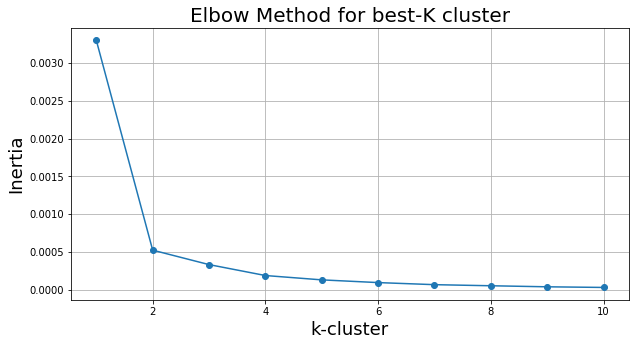

In [32]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(k_distances.keys(), k_distances.values(), marker='o')
plt.xlabel("k-cluster", fontsize=18)
plt.ylabel("Inertia", fontsize=18)
plt.title("Elbow Method for best-K cluster", fontsize=20)
plt.grid()

### Fit POIs to find recommended setup spots

In [33]:
# Fit X with 4 clusters
kmeans_clf = KMeans(n_clusters=3, random_state=0).fit(X)
centroids, labels = kmeans_clf.cluster_centers_, kmeans_clf.labels_
print(f"Centroids: \n{centroids}, \nLabels: {labels}")

Centroids: 
[[  5.45820526 100.30797188]
 [  5.43422953 100.31087106]
 [  5.45019598 100.30433157]], 
Labels: [1 2 1 1 2 1 1 1 1 2 2 1 1 2 0 0 2 1 1 2 2 2 2 1 1 2 1 0 2 2 1 2 1]


In [34]:
# Insert labels into poi_groupby_venues
loc_groupby_venues['Cluster Labels'] = labels
loc_groupby_venues

Venue  Venue Latitude  Venue Longitude  \
0                       7-Eleven        5.430053       100.312761   
1                       7-Eleven        5.451319       100.305213   
2              Bath & Body Works        5.435498       100.311048   
3                         CHANEL        5.438041       100.310257   
4                   Cold Storage        5.450468       100.306444   
5                          Daiso        5.434837       100.310826   
6                        Gravity        5.435698       100.309922   
7                 Gurney Paragon        5.435314       100.310941   
8                   Gurney Plaza        5.437529       100.309598   
9        Hairstory International        5.450269       100.305613   
10                    Happy Mart        5.451703       100.303717   
11                     Herbaline        5.436296       100.311632   
12                   Jaya Grocer        5.435679       100.311066   
13                    Kim's Mart        5.450908       100.304070   
14       Kim's Mart Korean Store        5.456346       100.307521   
15      Lotus's (formerly Tesco)        5.459069       100.308321   
16                    Marina Bay        5.442798       100.306613   
17               Marks & Spencer        5.436334       100.309016   
18                       Meijiya        5.431506       100.314866   
19            Miu Kitty Paradise        5.451520       100.304761   
20          Mount Erskine Market        5.448610       100.301709   
21           One Stop Handy Shop        5.451998       100.303808   
22                   Precinct 10        5.449251       100.306154   
23            Pulau Tikus Market        5.430481       100.311924   
24                         Shell        5.427940       100.315139   
25                      白云山Pasar        5.448722       100.301229   
0   Adventist Pharmacy & Cashier        5.432360       100.305353   
1            Georgetown Pharmacy        5.459201       100.308073   
2               Kedai Ubat Abadi        5.452237       100.302629   
3                  Pure Pharmacy        5.451639       100.304038   
4                        Watsons        5.437457       100.309606   
5                        Watsons        5.451302       100.304645   
6      Wellings Pharmacy Sdn Bhd        5.432649       100.309982   

    Cluster Labels  
0                1  
1                2  
2                1  
3                1  
4                2  
5                1  
6                1  
7                1  
8                1  
9                2  
10               2  
11               1  
12               1  
13               2  
14               0  
15               0  
16               2  
17               1  
18               1  
19               2  
20               2  
21               2  
22               2  
23               1  
24               1  
25               2  
0                1  
1                0  
2                2  
3                2  
4                1  
5                2  
6                1

In [35]:
# delete pharmacy coordinates

poi_groupby_venues = loc_groupby_venues.iloc[:-1*n_outlet, :]
poi_groupby_venues

Venue  Venue Latitude  Venue Longitude  Cluster Labels
0                   7-Eleven        5.430053       100.312761               1
1                   7-Eleven        5.451319       100.305213               2
2          Bath & Body Works        5.435498       100.311048               1
3                     CHANEL        5.438041       100.310257               1
4               Cold Storage        5.450468       100.306444               2
5                      Daiso        5.434837       100.310826               1
6                    Gravity        5.435698       100.309922               1
7             Gurney Paragon        5.435314       100.310941               1
8               Gurney Plaza        5.437529       100.309598               1
9    Hairstory International        5.450269       100.305613               2
10                Happy Mart        5.451703       100.303717               2
11                 Herbaline        5.436296       100.311632               1
12               Jaya Grocer        5.435679       100.311066               1
13                Kim's Mart        5.450908       100.304070               2
14   Kim's Mart Korean Store        5.456346       100.307521               0
15  Lotus's (formerly Tesco)        5.459069       100.308321               0
16                Marina Bay        5.442798       100.306613               2
17           Marks & Spencer        5.436334       100.309016               1
18                   Meijiya        5.431506       100.314866               1
19        Miu Kitty Paradise        5.451520       100.304761               2
20      Mount Erskine Market        5.448610       100.301709               2
21       One Stop Handy Shop        5.451998       100.303808               2
22               Precinct 10        5.449251       100.306154               2
23        Pulau Tikus Market        5.430481       100.311924               1
24                     Shell        5.427940       100.315139               1
25                  白云山Pasar        5.448722       100.301229               2

### Visualize the recommended locations and POIs related to them

In [36]:
# obtain the geographic coordinate of Tanjung Tokong
tokong_latitude, tokong_longitude = output_geo_coordinates("Tanjung Tokong, Penang")

# create map of Penang using latitude and longitude values
map_penang = folium.Map(location=[tokong_latitude, tokong_longitude], zoom_start=14)
poi_layer = folium.FeatureGroup(name="POI")


# obtain cluster label names
labels = list(set(poi_groupby_venues['Cluster Labels']))


# Configure color for neighborhoods
colors_array = cm.brg(np.linspace(0, 1, len(labels)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
color_codes = dict()
for hood, color in zip(labels, rainbow):
    color_codes.update({hood : color})

        
    
# add markers to Pharmacy locations
for lat, lng, venue, neighbor, neigh_lat, neigh_long in zip(pharmacy_venues['Venue Latitude'], 
                                     pharmacy_venues['Venue Longitude'], 
                                     pharmacy_venues['Venue'], 
                                     pharmacy_venues['Neighborhood'], 
                                     pharmacy_venues['Neighborhood Latitude'], 
                                     pharmacy_venues['Neighborhood Longitude']):
    folium.Marker(
        [lat,lng], 
        popup=f"{venue} [{neighbor}] ({lat:.6f}, {lng:.6f})").add_to(map_penang)


# add circle markers to recommended spot/location - centroids
for i, centroid in enumerate(centroids):
    latitude, longitude = centroid
    folium.features.CircleMarker(
        [latitude, longitude],
        radius=35,
        popup=f"Cluster-{i} ({latitude:.4f}, {longitude:.4f})",
        color=color_codes[i],
        fill=True,
        fill_color=color_codes[i],
        fill_opacity=0.3,
        parse_html=False).add_to(map_penang) 

    
# add circle markers to poi 
for i, (venue, latitude, longitude, label) in enumerate(zip(poi_groupby_venues['Venue'].tolist(), 
                                             poi_groupby_venues['Venue Latitude'].tolist(), 
                                             poi_groupby_venues['Venue Longitude'].tolist(),
                                             poi_groupby_venues['Cluster Labels'].tolist())):

    venue = venue.replace("'","")  # note that apostrophe in popup will stop map from displaying
    
    folium.CircleMarker(
        location=[latitude, longitude],
        radius=5,
        popup=f"{venue} | Cluster-{label}: ({latitude:.4f},{longitude:.4f})", # note that apostrophe will stop map from displaying
        color=color_codes[label],
        fill=True,
        fill_color=color_codes[label],
        fill_opacity=0.7,
        parse_html=False).add_to(map_penang) 



map_penang

<a id='Results/Discussion'></a>
### Results/Discussion

Based on the marker, there are only 7 existing outlets available in 3 different neighborhoods, 'Tanjung Bungah','Tanjung Tokong' and 'Georgetown', having Tanjung Tokong with the most outlets at one close area and another 2 outlets nearer to the bay area. Georgetown area shares the same number of outlets, however the outlet locations are equally spaced. 

The POIs on the Tanjung Tokong area are the most densed (displayed in small green circle markers) which see the setup of 3 outlets. This is followed by Georgetown area with 13 POIs. 

The analysis shows the larger circle markers which recommend the area where new outlets can be setup. Judging from the 3, the violet region is the best as it will not get so much competition from the existing outlets and at the same time, the area is not very far from the POIs displayed in the green region. 


<a id='Conclusion'></a>
### Conclusion

The objective of this project is to provide a strategic location for new pharmacy outlets based on the POIs, the likely competition from the existing outlets and how near the locations are to the city and residential areas. 

With the venue and neighborhood information obtained by Foursquare API, I am able to have clearer view on the density of existing outlets and POIs to decide whether the regions suggested are potentially suitable for new oulets. 

The recommended areas from the 3 large circle markers will allow potential business owners to fathom the demographic and density of the landmarks, prior to the considerationof other variable factors such as traffic conditions, accessibility, prices and business models among others, to land on the decision on whether to start an outlet at the specified location. 